# This notebook is primarily a testing ground used while developing new functionality. Some examples of how to use the functions can be found here, but the notebook is not intended as guide/documentation

In [1]:
import numpy as np 
import pandas as pd

import ExcessMortalityFunctions as emf
from importlib import reload
reload(emf)

from scipy.stats import poisson

import matplotlib.pyplot as plt

# import sys
 
# # setting path
# sys.path.append('../Functions')
# import PandemiXSignaturesForSubfolders as ps

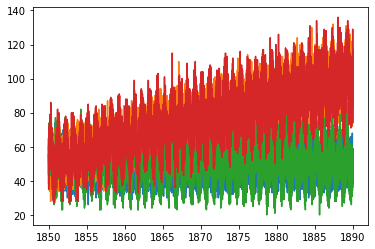

In [2]:
# Generate some data for testing
d1 = np.datetime64('1850-01-01')
d2 = np.datetime64('1890-01-01')
ts = np.arange(d1,d2)

# Constant
curMean = 50 
curBase = poisson.rvs(curMean,size = len(ts))

# Linearly increasing
curMean2 = 100
allMeans = np.linspace(curMean,curMean2,len(ts))
curBase2 = poisson.rvs(allMeans,size = len(ts))

# Sinusoidal
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))


# Sinusoidal and linear
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
curBase4 = np.round(poisson.rvs(allMeans,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))

# Plot
fig,ax = plt.subplots()
ax.plot(ts,curBase)
ax.plot(ts,curBase2)
ax.plot(ts,curBase3)
ax.plot(ts,curBase4)


In [3]:

df = pd.DataFrame(
    index = ts,
    data={
        'Base':curBase,
        'Base2':curBase2,
        'Base3':curBase3,
        'Base4':curBase4,
        }
)

# df.plot()


In [51]:
reload(emf)
%matplotlib widget
numYears = 5

In [85]:

# pdSeries = df.Base
# curFrame = pdSeries.to_frame()
# curFrame['Year'] = curFrame.index.year 
# curFrame['Month'] = curFrame.index.month
# curFrame['Day'] = curFrame.index.day
# curFrame['Week'] = curFrame.index.isocalendar()
# # curFrame.pivot_table(values=pdSeries.name,index=['Month','Day'],columns='Year')
# # curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')
# # curPivot
# curFrame

In [97]:
pdSeries = df.Base


isoCal = pdSeries.index.isocalendar()


curFrame = pdSeries.to_frame().join(isoCal)
curFrameWeek = curFrame.groupby([curFrame.year,curFrame.week]).sum().drop(columns='day')
curPivot = curFrameWeek.pivot_table(pdSeries.name,index='year',columns='week')


# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)


# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='year') # Melt pivottable
curMean['Date'] = pd.to_datetime(curMean.year.astype(str)+'-'+curMean.week.astype(str).str.zfill(2)+'-1',format='%G-%V-%w') # Determine date from year and week number
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['year','week']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curStd = curStd.reset_index().melt(id_vars='year') # Melt pivottable
curStd['Date'] = pd.to_datetime(curStd.year.astype(str)+'-'+curStd.week.astype(str).str.zfill(2)+'-1',format='%G-%V-%w') # Determine date from year and week number
curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['year','week']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns

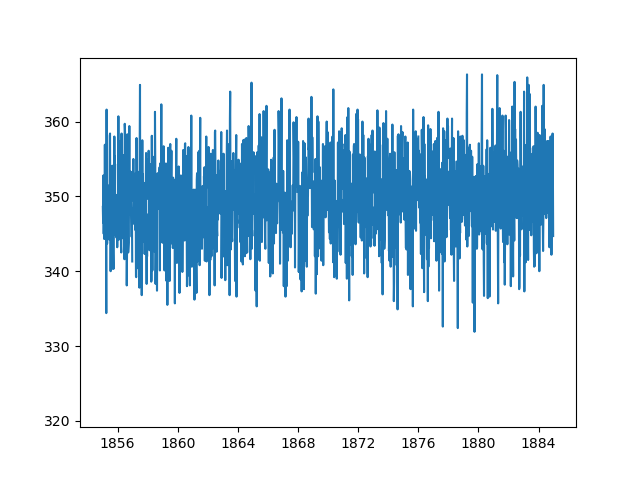

In [98]:
fig,ax = plt.subplots()
ax.plot(curMean)

In [69]:
curMean.year.astype(str)+'-'+curMean.week.astype(str).str.zfill(2)+'-1'

0       1850-01-1
41      1850-02-1
82      1850-03-1
123     1850-04-1
164     1850-05-1
          ...    
2008    1890-49-1
2049    1890-50-1
2090    1890-51-1
2131    1890-52-1
2172    1890-53-1
Length: 2173, dtype: object

In [66]:
# pd.to_datetime('1889-53-1',format='%G-%V-%w')

In [70]:
curMean

,year,week,value,day
0,1850,1,NaN,1.0
41,1850,2,NaN,1.0
82,1850,3,NaN,1.0
123,1850,4,NaN,1.0
164,1850,5,NaN,1.0
...,...,...,...,...
2008,1890,49,NaN,1.0
2049,1890,50,NaN,1.0
2090,1890,51,NaN,1.0
2131,1890,52,NaN,1.0


In [24]:
curData = df.Base4 
curData = df.Base4.rolling(window=7,center=True).mean()
curMean,curStd = emf.rnMean(curData,timeResolution='Day')

TypeError: cannot perform __rmul__ with this index type: DatetimeArray

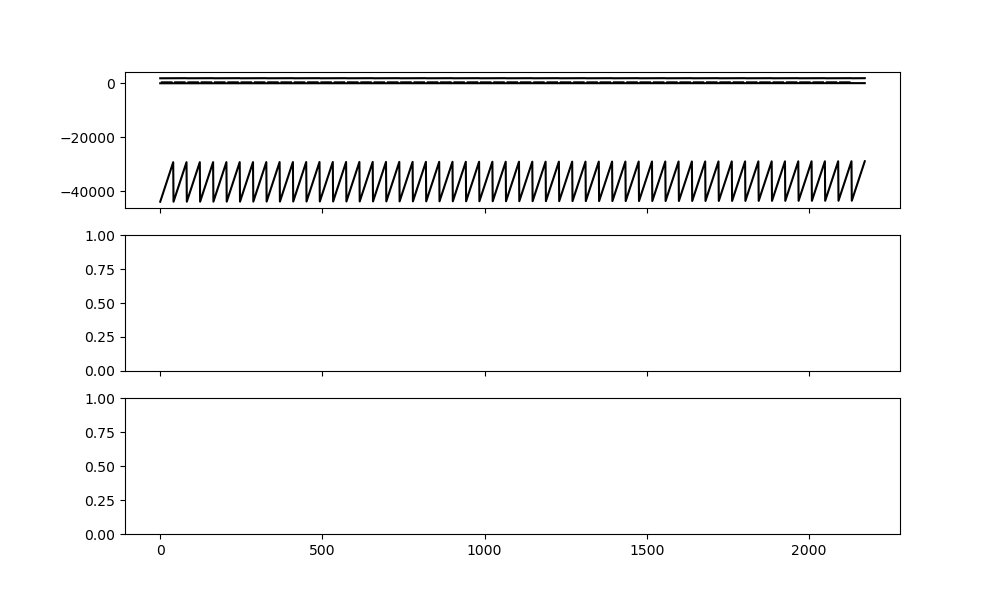

In [88]:

# fig,ax = plt.subplots()
# ax.plot(curMean)
# ax.plot(curData,'.')

fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6),sharex=True)
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData,'.-',lw=0.5)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean,'.-',lw=0.5)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()


In [22]:
numYears = 5

pdSeries = df.Base
curFrame = pdSeries.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day
# curFrame.pivot_table(values=pdSeries.name,index=['Month','Day'],columns='Year')
curPivot = curFrame.pivot_table(values=pdSeries.name,columns=['Month','Day'],index='Year')
curPivot

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

curMean.iloc[:,50:]


# # Reshape pivottables into series
# curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
# curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)
# # curStd = curStd.reset_index().melt(id_vars='Year')
# # curStd['Date'] = pd.to_datetime(dict(year=curStd.Year,month=curStd.Month,day=np.ones(len(curStd.Year))))
# # curStd = curStd.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'StandardDeviation'}).iloc[:,0]

# # curMean = curMean[~(curMean.Day == 29) & (curMean.Month == 2)] 

curMean.loc[:,(2,29)] = (curMean.loc[:,(2,28)] + curMean.loc[:,(3,1)])/2
curMean.iloc[:,55:]

Month    2                              3                           ...    12  \
Day      25    26    27    28     29    1     2     3     4     5   ...    22   
Year                                                                ...         
1850    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1851    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1852    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1853    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1854    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1855   49.6  47.4  51.1  51.8  53.95  56.1  49.6  51.9  46.9  50.0  ...  49.1   
1856   52.2  48.5  50.8  51.8  53.60  55.4  48.4  47.8  49.3  51.4  ...  46.9   
1857   51.9  45.8  51.0  49.6  52.30  55.0  48.6  48.5  48.8  51.3  ...  48.5   
1858   53.6  46.4  49.6  50.7  51.70  52.7  48.4  47.2  49.0  50.7  ...  48.4   
1859   52.9  47.1  47.0  48.8  51.35  53.9  47.2  49.0  49.7  47.1  ...  49.1   
1860   51.4  46.8  48.9  48.4  50.40  52.4  48.5  49.5  48.8  46.5  ...  48.1   
1861   50.5  46.5  50.4  48.8  51.90  55.0  50.9  51.1  48.1  44.8  ...  50.0   
1862   51.5  48.9  49.2  49.7  52.40  55.1  49.3  49.0  48.1  47.6  ...  48.6   
1863   51.4  48.3  51.8  47.4  51.90  56.4  48.5  48.2  48.0  47.2  ...  48.1   
1864   53.1  49.3  50.6  47.8  50.75  53.7  49.2  46.3  47.4  48.7  ...  48.9   
1865   54.6  50.6  47.7  47.8  51.15  54.5  46.6  46.3  48.5  48.0  ...  50.7   
1866   52.1  50.4  47.4  45.7  49.60  53.5  45.7  47.6  47.3  49.2  ...  50.9   
1867   50.7  50.6  48.4  45.9  49.75  53.6  49.4  50.1  49.0  47.2  ...  52.8   
1868   48.9  52.5  48.5  47.3  50.10  52.9  48.8  52.9  49.3  47.3  ...  53.7   
1869   47.7  52.8  53.0  46.8  51.05  55.3  49.5  54.4  49.2  48.1  ...  53.7   
1870   46.9  54.3  52.6  46.1  50.35  54.6  50.7  54.3  48.7  49.8  ...  52.5   
1871   49.9  54.2  52.6  47.5  51.45  55.4  49.5  52.3  50.5  50.9  ...  53.8   
1872   49.2  54.0  52.2  46.4  50.40  54.4  46.0  51.3  48.1  52.7  ...  54.1   
1873   48.5  53.2  52.5  45.7  49.60  53.5  48.0  49.9  49.4  52.8  ...  54.6   
1874   46.7  51.1  50.8  45.2  49.35  53.5  46.7  49.8  48.2  50.4  ...  54.4   
1875   46.1  50.4  51.8  46.0  49.90  53.8  47.9  50.9  48.0  51.0  ...  55.6   
1876   42.8  51.8  51.2  45.1  48.65  52.2  49.0  52.2  46.7  51.4  ...  52.6   
1877   44.9  51.0  50.6  45.9  50.05  54.2  50.4  51.2  50.9  52.5  ...  52.6   
1878   46.2  51.4  48.1  46.2  50.25  54.3  48.3  51.4  49.6  51.7  ...  51.8   
1879   46.7  52.7  48.9  47.9  49.90  51.9  49.6  50.3  51.4  53.2  ...  50.8   
1880   46.5  50.1  49.0  46.0  49.15  52.3  48.1  49.4  52.1  50.9  ...  50.6   
1881   48.5  49.5  46.9  48.8  50.10  51.4  48.6  47.1  52.5  50.3  ...  51.5   
1882   46.9  49.1  47.5  49.8  49.20  48.6  48.3  47.6  49.4  47.6  ...  48.4   
1883   48.2  48.6  47.5  50.3  49.50  48.7  50.0  46.7  50.6  50.5  ...  48.7   
1884   49.7  49.3  44.9  49.9  50.25  50.6  49.4  49.4  51.5  50.0  ...  49.1   
1885    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1886    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1887    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1888    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1889    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

Month                                                        
Day      23    24    25    26    27    28    29    30    31  
Year                                                         
1850    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1851    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1852    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1853    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1854    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1855   53.1  45.8  4

In [228]:
df.groupby(pd.Grouper(freq='1M')).sum()
dfMonth = df.groupby([df.index.year.rename('Year'),df.index.month.rename('Month')]).sum()
dfMonth


Base  Base2   Base3   Base4
Year Month                             
1850 1      1520   1541  1562.0  1727.0
     2      1393   1345  1628.0  1609.0
     3      1559   1601  1878.0  1824.0
     4      1516   1523  1774.0  1821.0
     5      1585   1626  1783.0  1713.0
...          ...    ...     ...     ...
1889 8      1479   3086  1292.0  2892.0
     9      1493   2969  1220.0  2646.0
     10     1536   3093  1243.0  2784.0
     11     1486   3017  1309.0  2747.0
     12     1579   3171  1491.0  3033.0

[480 rows x 4 columns]

In [229]:

# curTest  = df.Base

# # # # Start by grouping data by month, in case its daily
# curTest = curTest.groupby([curTest.index.year.rename('Year'),curTest.index.month.rename('Month')]).sum()
# curTest = curTest.reset_index()
# # # curTest = curTest.reset_index().melt(id_vars='Year')
# curTest['Date'] = pd.to_datetime(dict(year=curTest.Year,month=curTest.Month,day=np.ones(len(curTest.Year))))
# # curTest = curTest.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'Base':'Baseline'})

# curTest = curTest.drop(columns=['Year','Month']).set_index('Date')
# curTest = curTest.iloc[:,0]

In [230]:
# curData-curMean
# curData 


In [231]:
pdSeries = df.Base
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()
serMonth

Year  Month
1850  1        1520
      2        1393
      3        1559
      4        1516
      5        1585
               ... 
1889  8        1479
      9        1493
      10       1536
      11       1486
      12       1579
Name: Base, Length: 480, dtype: int32

In [243]:
pdSeries = df.Base2
serYear = pdSeries.groupby(pdSeries.index.year.rename('Year')).sum()
serYear.rolling(window=7).sum()

numYears = 5
# Calculate sum of surrounding years and current year
curSum = serYear.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - serYear)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = serYear.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - serYear.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

curData = emf.groupByYear(pdSeries)


curMean = curMean.reset_index()
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=np.ones(len(curMean.Year)),day=np.ones(len(curMean.Year))))
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year']).rename(columns={'value':'Baseline'}).iloc[:,0]
curMean
# serYear

Date
1850-01-01        NaN
1851-01-01        NaN
1852-01-01        NaN
1853-01-01        NaN
1854-01-01        NaN
1855-01-01    20760.6
1856-01-01    21253.8
1857-01-01    21710.0
1858-01-01    22160.3
1859-01-01    22578.6
1860-01-01    23031.5
1861-01-01    23484.1
1862-01-01    23954.4
1863-01-01    24426.0
1864-01-01    24895.4
1865-01-01    25370.5
1866-01-01    25770.5
1867-01-01    26226.2
1868-01-01    26677.9
1869-01-01    27141.9
1870-01-01    27584.0
1871-01-01    28135.1
1872-01-01    28564.2
1873-01-01    29002.8
1874-01-01    29438.8
1875-01-01    29894.0
1876-01-01    30290.9
1877-01-01    30809.2
1878-01-01    31272.0
1879-01-01    31729.4
1880-01-01    32124.8
1881-01-01    32533.8
1882-01-01    32986.1
1883-01-01    33456.3
1884-01-01    33920.4
1885-01-01        NaN
1886-01-01        NaN
1887-01-01        NaN
1888-01-01        NaN
1889-01-01        NaN
Name: Base2, dtype: float64

In [246]:
curMean

curMean,curStd = emf.rnMean(df.Base2,timeResolution='Year')
curData = emf.groupByYear(df.Base2)
# curData
# curMean
# # curStd
# # curMean - curData 
# curMean 
# curData.index

In [267]:
pdSeries.index[((curDates.month == 2) & (curDates.day == 29))]

DatetimeIndex(['1852-02-29', '1856-02-29', '1860-02-29', '1864-02-29',
               '1868-02-29', '1872-02-29', '1876-02-29', '1880-02-29',
               '1884-02-29', '1888-02-29'],
              dtype='datetime64[ns]', freq=None)

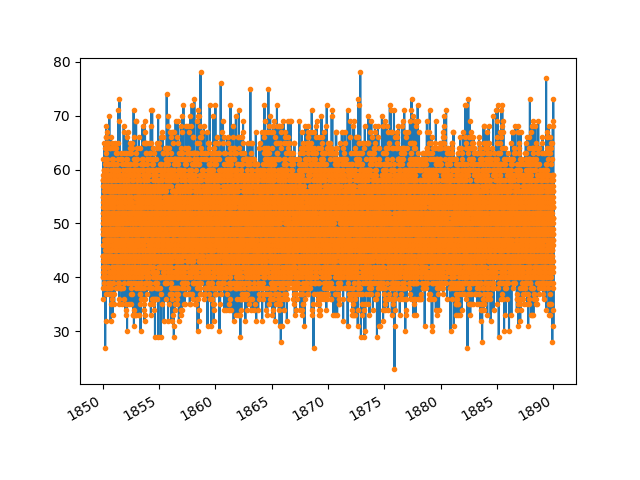

In [269]:
pdSeries = df.Base
curDates = pdSeries.index
nonLeapDay = ~((curDates.month == 2) & (curDates.day == 29))
pdSeries.loc[nonLeapDay]

fig,ax = plt.subplots()
pdSeries.loc[nonLeapDay].plot(ax=ax)
ax.plot(pdSeries.loc[nonLeapDay],'.')

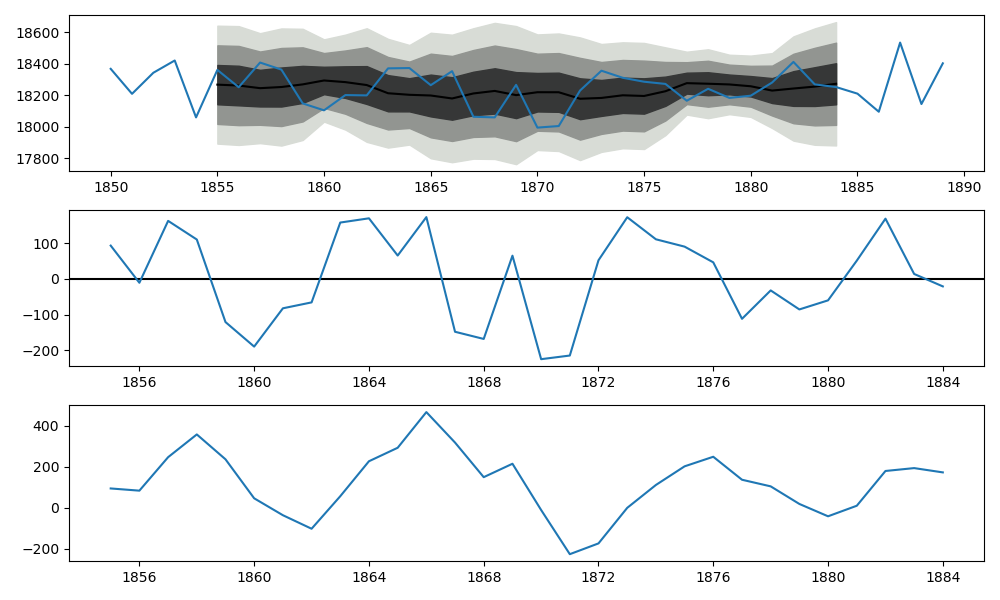

In [254]:

curData = emf.groupByYear(df.Base3)
curMean,curStd = emf.rnMean(curData,timeResolution='Year')

fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()

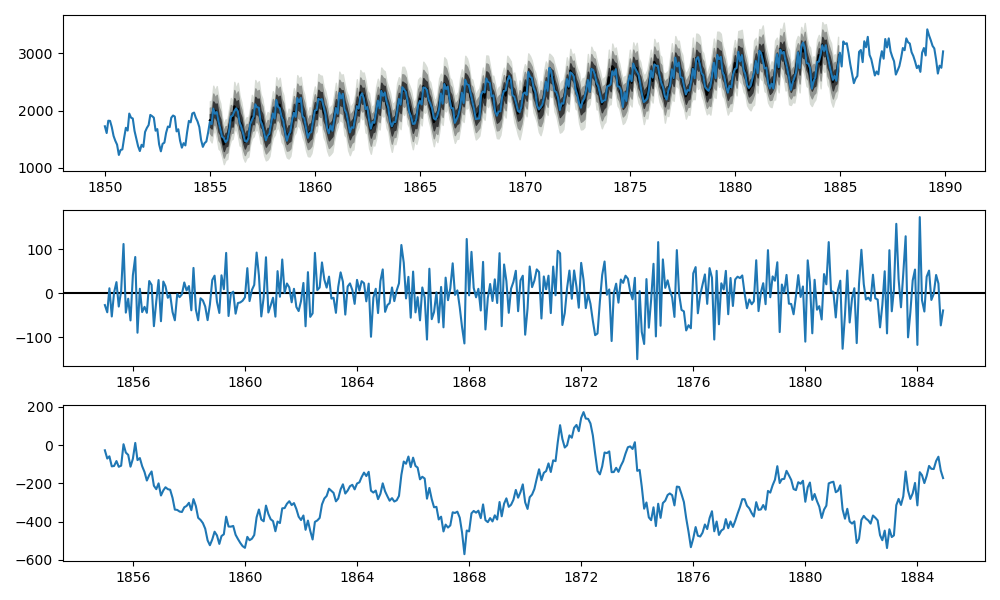

In [235]:
# curData = df['Base']
curData = emf.groupByMonth(df['Base4'])
curMean,curStd = emf.rnMean(curData)
# curMean2,curStd2 = emf.rnMean(curData)

%matplotlib widget
fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,6))
ax.plot(curMean,color='k')
ax.fill_between(x=curMean.index,y1=curMean-3*curStd,y2=curMean+3*curStd,color='xkcd:light gray')
ax.fill_between(x=curMean.index,y1=curMean-2*curStd,y2=curMean+2*curStd,color='xkcd:gray')
ax.fill_between(x=curMean.index,y1=curMean-curStd,y2=curMean+curStd,color='xkcd:dark gray')
ax.plot(curData)
# ax.plot(curMean2)
ax2.axhline(0,color='k')
ax2.plot(curData-curMean)

ax3.plot((curData-curMean).cumsum())

fig.tight_layout()

# # curMean.melt(id_vars=['index'])
# curMean = curMean.reset_index().melt(id_vars='Year')
# curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=np.ones(len(curMean.Year))))

# curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'Baseline'})

In [236]:
pdSeries = df.Base 
numYears = 5 

# Start by grouping data by month, in case its daily
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

In [237]:
# curMean.T.plot()


In [238]:

# # dfMonth.loc[1850:1852]

# curSeries = df['Base']
# serMonth = curSeries.groupby([curSeries.index.year.rename('Year'),curSeries.index.month.rename('Month')]).sum()
# # serMonth.pivot_table('Base',index='Year',columns='Month')
# curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# numYears = 2
# (curPivot.rolling(window=(numYears*2)+1,center=True).sum() - curPivot)/(numYears*2)

# curMean,curStd = emf.rnMean(df['Base'])
# curStd
pdSeries = df['Base']
numYears = 5

# Start by grouping data by month, in case its daily
serMonth = pdSeries.groupby([pdSeries.index.year.rename('Year'),pdSeries.index.month.rename('Month')]).sum()

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table('Base',index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()
# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
curMean = (curSum - curPivot)/(numYears*2)

# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum()
curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2)).pow(0.5)

# curBase = (curPivot.rolling(window=(2*numYears)+1,center=True).sum() - curPivot)/(2*numYears)
# curBase2 = (curPivot.pow(2).rolling(window=(numYears*2)+1,center=True).sum() - curPivot.pow(2))/(numYears*2)


# curBase2 - curBase.pow(2)
# # curBase2.loc[1860]
# # curMeanSqr.loc[1860]
# # curMeanSqr.pow(0.5)
# # curPivot.pow(2)
# # curSumSqr
# # curBase 
# # curBase2
curStd

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,47.278325,37.757781,22.697136,23.724460,42.174518,27.209557,35.905571,21.111371,23.752895,25.277658,35.997361,22.668039
1856,45.948232,40.830013,24.220033,27.171492,39.843318,23.148434,36.030681,35.445874,22.351957,26.485656,32.109812,20.730654
1857,42.677980,41.759310,42.270084,26.783577,45.771170,24.713559,38.003158,35.520276,35.970683,27.202206,32.328934,25.377155
1858,40.187685,29.336155,42.650791,26.858146,45.122500,22.291030,34.767945,36.733636,33.440096,30.434191,30.391611,26.452977


In [239]:

# dfMonth.loc[1850:1860]
# dfMonth.xs(12,level=1).pivot_table('Base')
# dfMonth.pivot('Base')
# dfMonth.unstack()

curPivot = dfMonth.pivot_table('Base',index='Year',columns='Month')
# dfMonth.pivot_table('Base',index='Month',columns='Year')


curPivot = curPivot.iloc[:11,:]

# curPivot.rolling(window=numYears)

In [240]:

numYears = 2
(curPivot.rolling(window=(numYears*2)+1,center=True).sum() - curPivot)/(numYears*2)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,1565.00,1397.50,1544.50,1482.75,1552.75,1487.25,1551.50,1514.75,1503.75,1531.25,1519.75,1550.50
1853,1539.25,1394.25,1549.25,1498.25,1559.00,1501.25,1524.25,1535.00,1486.25,1554.75,1501.75,1550.00
1854,1567.75,1407.75,1547.00,1497.00,1565.50,1497.00,1546.25,1550.50,1497.50,1563.25,1508.00,1559.50
1855,1582.50,1399.75,1547.25,1482.25,1572.00,1481.25,1549.50,1522.25,1509.25,1556.50,1517.75,1547.75
1856,1561.75,1408.75,1536.50,1500.00,1553.75,1492.75,1543.75,1548.25,1510.75,1565.75,1498.50,1551.00
1857,1569.75,1411.00,1530.75,1503.25,1565.25,1504.25,1550.75,1565.50,1517.00,1568.00,1518.50,1557.25
1858,1570.50,1406.50,1538.75,1505.25,1570.75,1503.75,1547.25,1535.50,1501.25,1572.25,1508.75,1533.75
